kaggle dataset link - https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## ***Pseudo Code***
i chose to fit the data on the Distilbert Transformer

**Preprocessing**

Using DistilBertTokenizerFast i created `tokens` that is a dictionary consisting of keys : input_ids - tokens in form of tensors, attention_mask that indicates padding pattern ,fixing the max_length of each sentance to `128`.

`labels` - list of all sentiment labels of the dataset

Using torch.utils.data.TensorDataset i created training and testing datasets which i passed to DataLoader to make it iterable batchwise.

**Transformer class**

DistilBertConfig i sliced off an attention head and changed to hidden_size to *770* to adjust to the new num_attention-heads as given in the ps.

My Model consists of  the distilbert transformer followed by a dropout layer (For Regularization)

Upon trainng the model on the following hyperparameters i got a Test Accuracy close to ***84%***,the model returned the output and the attention weights (relative influence of each word on every other word - for plotting attention map)

* Epochs - 4
* lr - 3e-5
* regularization factor - 1e-3
* Batch size - 128


`lr scheduler`-torch.optim.lr_schedulerReduceLROnPlateau : To reduce the lr by a factor 0.5 if the Test Accuracy doesn't increase.


I noticed a big reduction in test accuracy from around ***90%*** to ***84%*** just by reducing one attention head indicating there are lesser Query,key,Value matrices in the transformer than before so lesser weights therefore lesser opportunities to learn.

**Attention Map**

Since i gave output_attentions=`True`, the model also returns attention weights of each head that has multiple layers.
i used matplotlib matshow on the atttention weights on a sample review to plot the attention map.





In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import torch
from torch import nn
from transformers import AutoModel,AutoTokenizer,DistilBertForSequenceClassification,DistilBertTokenizerFast,DistilBertConfig
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.parallel import DataParallel
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
import csv

In [3]:
df=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
l=[]
for i in range(50000):
    l.append(len(df.review[i].split(' ')))

In [5]:
np.array(l).mean()

231.14594

In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.device_count() > 1:
    print(f'Number of GPUs : {torch.cuda.device_count()}')

Number of GPUs : 2


In [7]:
tokenizer=DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
tokens=tokenizer(list(df.review),padding=True,truncation=True,max_length=128,return_tensors="pt")
labels=[1 if y=='positive' else 0 for y in df.sentiment]


In [9]:
BATCH_SIZE=128
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_split=int(0.8*len(labels))
input_ids =tokens['input_ids']
attention_mask = tokens['attention_mask']
labels=torch.tensor(labels)

train_dataset=TensorDataset(input_ids[:train_split],attention_mask[:train_split],labels[:train_split])
test_dataset=TensorDataset(input_ids[train_split:],attention_mask[train_split:],labels[train_split:])

train_dataloader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [10]:
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        config = DistilBertConfig.from_pretrained("distilbert-base-uncased",output_attentions=True)
        config.num_attention_heads -= 1
        config.hidden_size=770
        self.distilbert=DistilBertForSequenceClassification(config)
        

        self.drop=nn.Dropout(0.5)
    def forward(self,input_ids,attention_mask):
        out=self.distilbert(input_ids=input_ids,attention_mask=attention_mask)
        return  self.drop(out.logits),out.attentions
        

In [11]:
model_0 = Transformer().to(device)
model_0=DataParallel(model_0)# To utilize both T4 GPUs

In [12]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(params=model_0.parameters(),
                          lr=3e-5,weight_decay=1e-3)


lr_scheduler=ReduceLROnPlateau(optimizer=optimizer,factor=0.5,patience=1,mode='max')

In [13]:
def accuracy_fn(y_true,y_pred):
    correct=(y_true==y_pred).sum()
    return correct/len(y_true)*100

In [14]:
train_losses=[]
test_losses=[]
train_accuracies=[]
test_accuracies=[]
epochs=4
for epoch in range(epochs):
    model_0.train()
    train_loss,train_acc=0,0
    test_loss,test_acc=0,0
    for batch in tqdm(train_dataloader,desc=f"Training epoch: {epoch}",total=len(train_dataloader),unit='batch'):
        batch=tuple(x.to(device) for x in batch)
        input_ids,attention_mask,labels=batch
        logits,_=model_0(input_ids,attention_mask)
        
        loss=loss_fn(logits,labels)
        train_loss+=loss
        
        acc=accuracy_fn(y_true=labels,y_pred=logits.softmax(dim=1).argmax(dim=1))
        train_acc+=acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss/=len(train_dataloader)
    train_acc/=len(train_dataloader)
        
        
    model_0.eval()
    with torch.inference_mode():
        for test_batch in test_dataloader:
            test_batch=tuple(x.to(device) for x in test_batch)
            input_ids,attention_mask,test_labels=test_batch
            test_logits,_=model_0(input_ids,attention_mask)
            test_loss+=loss_fn(test_logits,test_labels)
            test_acc+=accuracy_fn(y_true=test_labels,y_pred=test_logits.softmax(dim=1).argmax(dim=1))
            
        test_acc/=len(test_dataloader)
        test_loss/=len(test_dataloader)
    
    lr_scheduler.step(test_acc)
    train_losses.append(train_loss.item())
    train_accuracies.append(train_acc.item())
    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc.item())
    print(f"Train loss:{train_loss:.4f} | Train Accuracy:{train_acc:.2f}% | Test Loss:{test_loss:.4f} | Test Accuracy:{test_acc:.2f}%")  
        

Training epoch: 0:   0%|          | 0/313 [00:00<?, ?batch/s]

Train loss:0.6029 | Train Accuracy:63.41% | Test Loss:0.4107 | Test Accuracy:81.02%


Training epoch: 1:   0%|          | 0/313 [00:00<?, ?batch/s]

Train loss:0.4575 | Train Accuracy:75.42% | Test Loss:0.3745 | Test Accuracy:83.20%


Training epoch: 2:   0%|          | 0/313 [00:00<?, ?batch/s]

Train loss:0.4171 | Train Accuracy:77.71% | Test Loss:0.3646 | Test Accuracy:83.68%


Training epoch: 3:   0%|          | 0/313 [00:00<?, ?batch/s]

Train loss:0.3893 | Train Accuracy:79.04% | Test Loss:0.3642 | Test Accuracy:83.70%


Text(0.5, 1.0, 'Training and Testing Accuracy vs epochs')

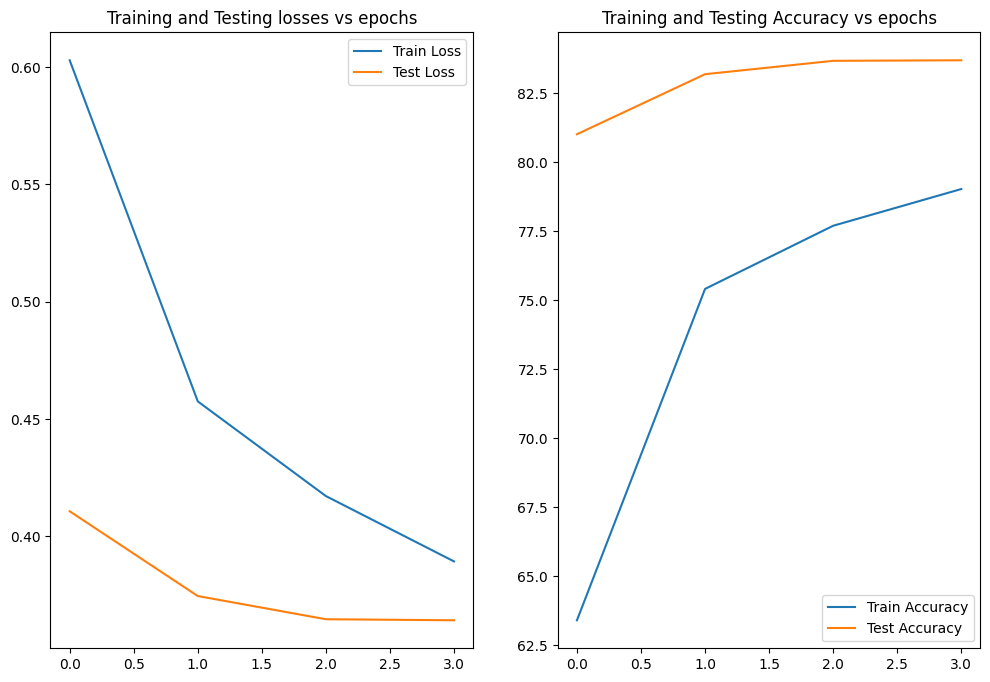

In [15]:
x=[i for i in range(epochs)]
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.plot(x,train_losses,label="Train Loss")
plt.plot(x,test_losses,label="Test Loss")
plt.legend()
plt.title("Training and Testing losses vs epochs")

plt.subplot(1,2,2)
plt.plot(x,train_accuracies,label="Train Accuracy")
plt.plot(x,test_accuracies,label="Test Accuracy")
plt.legend()
plt.title("Training and Testing Accuracy vs epochs")

## Evaluation

In [16]:
pred_labels=[]
test_dataloader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_acc,test_loss=0,0
model_0.eval()
with torch.inference_mode():
    for test_batch in test_dataloader:
        test_batch=tuple(x.to(device) for x in test_batch)
        input_ids,attention_mask,test_labels=test_batch
        test_logits,_=model_0(input_ids,attention_mask)
        test_loss+=loss_fn(test_logits,test_labels)
        test_preds=test_logits.softmax(dim=1).argmax(dim=1)
        test_acc+=accuracy_fn(y_true=test_labels,y_pred=test_preds)
        
        pred_labels.extend(test_preds)

    test_acc/=len(test_dataloader)
    test_loss/=len(test_dataloader)
print(f"Test Loss:{test_loss} | Test Accuracy:{test_acc}")

Test Loss:0.3663013279438019 | Test Accuracy:83.77175903320312


In [17]:
pred_labels=[int(i.item()) for i in pred_labels]

## Visualising an attention map for a random sample using attention weights




In [18]:
sample_text='This was an amazing movie, must watch!'
tokens=tokenizer(sample_text,padding=True,truncation=True,max_length=128,return_tensors="pt")

model_0.eval()
with torch.inference_mode():
    output,attention_weights=model_0(tokens['input_ids'],tokens['attention_mask'])#

    
    

In [19]:
output.softmax(dim=1).argmax(dim=1)
#outputs 1 -> Positive

tensor([1], device='cuda:0')

In [20]:
attention_weights[5].shape #11 attention heads

torch.Size([1, 11, 11, 11])

In [21]:
tokens['input_ids']

tensor([[ 101, 2023, 2001, 2019, 6429, 3185, 1010, 2442, 3422,  999,  102]])

In [22]:
words=tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
attention=attention_weights[0][0][0].cpu().numpy()

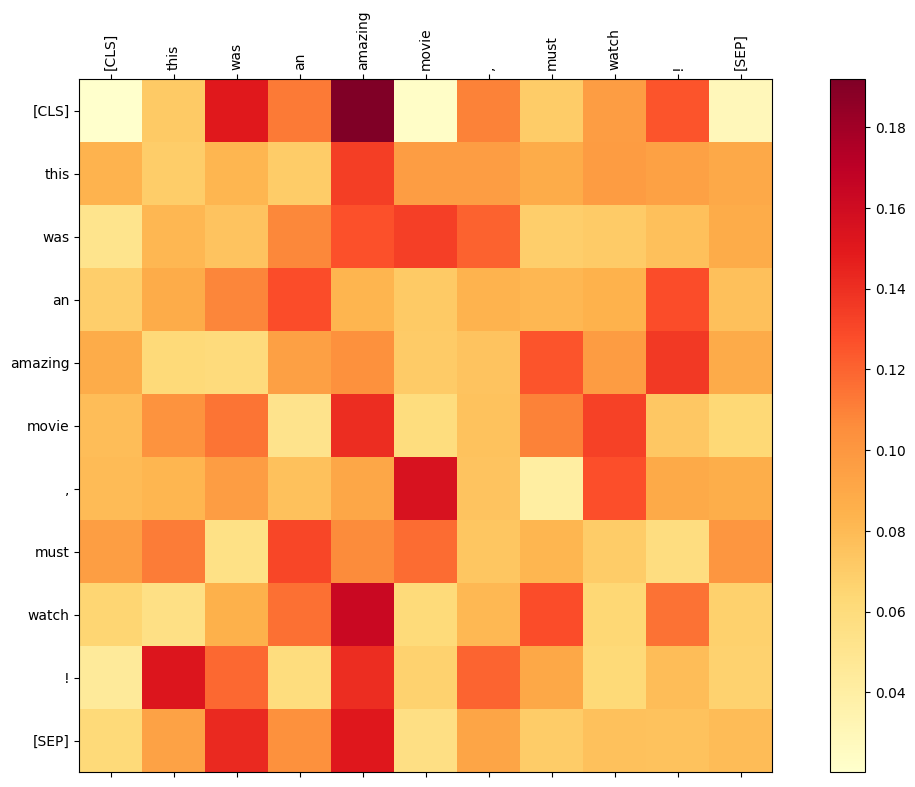

In [23]:
ig, ax = plt.subplots(figsize=(15,9))
cax = ax.matshow(attention, cmap='YlOrRd')

ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation=90)
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)

# Show color bar
plt.colorbar(cax)

# Show the plot
plt.show()

## Saving model weights (state dict)

In [24]:
model_0_state_dict=model_0.state_dict()
path_0="/kaggle/working/model_0_weights.pkl"

with open(path_0,'wb') as f:
    pickle.dump(model_0_state_dict,f)

## Saving model Predictions

In [25]:
with open("model_0_preds.csv",'w') as f:
    wobj=csv.writer(f)
    for i in pred_labels:
        wobj.writerow([i])